# Домашнее задание: подготовка и обучение WGAN-GP



### Разбалловка:

- Код генератора (5 баллов)
- Код критика (7 баллов)
- Gradient penalty (3 балла)
- Код обучения (5 баллов)
- Оценка fid:
    *   <= 60 -- 10б
    *   <= 85 -- 8б
    *   <= 110 -- 6б
    *   <= 135 -- 4б
    *   <= 160 -- 2б
    *   <= 200 -- 0б



# Подготовка данных

In [2]:
# Установка необходимых библиотек
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
from tqdm import tqdm
import tempfile
from PIL import Image



In [3]:
# Установка seed для воспроизводимости и проверка доступности куды
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Установка kagglehub, если вы работаете не в Google Colab
!pip install kagglehub

Мы будем работать с датасетом с котиками с кагла. Датасет можно найти [тут](https://www.kaggle.com/datasets/crawford/cat-dataset?select=CAT_04).

Ниже мы приведём способо скачивания и подгрузки данных, однако вы можете также напряму скачать датасет с кагла и перенести его в интересующую папку.

In [5]:
import os
import shutil
import kagglehub

target_folder = '/content/faces'
os.makedirs(target_folder, exist_ok=True)

# Загружаем датасет (берётся из кэша)
path = kagglehub.dataset_download("splcher/animefacedataset")

# Копируем содержимое, даже если папка уже существует
for file in os.listdir(path):
    src = os.path.join(path, file)
    dst = os.path.join(target_folder, file)

    if os.path.isdir(src):
        shutil.copytree(src, dst, dirs_exist_ok=True)
    else:
        shutil.copy2(src, dst)

print("Датасет успешно скопирован в папку:", target_folder)

Using Colab cache for faster access to the 'animefacedataset' dataset.
Датасет успешно скопирован в папку: /content/faces


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Загрузка данных
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # [-1, 1]
])

dataset = datasets.ImageFolder(root=target_folder, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)

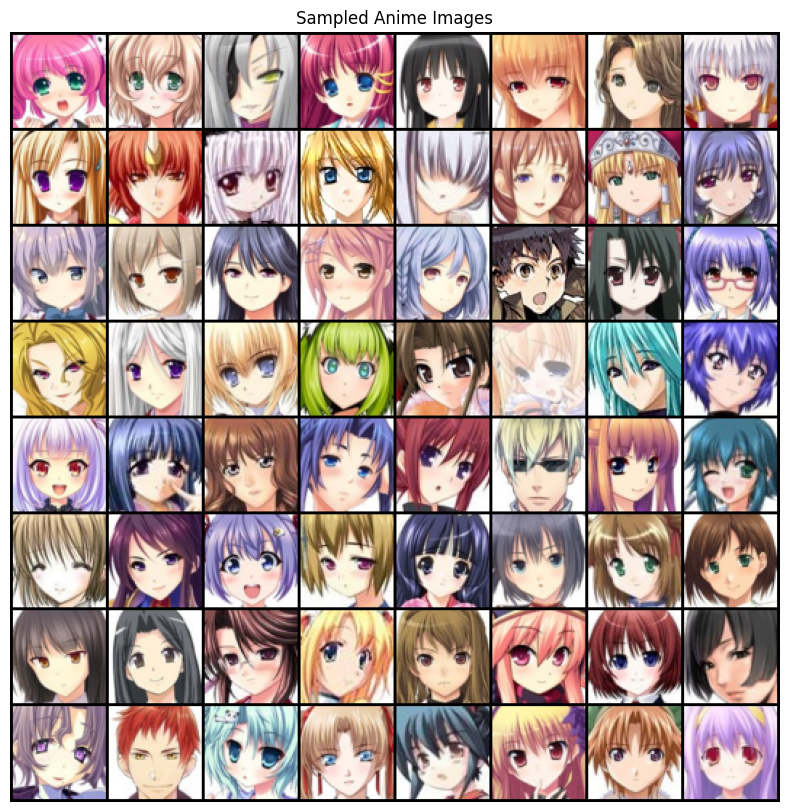

In [8]:
# Отрисовка сэмплов
# Посмотрим на один батч изображений
data_iter = iter(dataloader)
images, _ = next(data_iter)

# Отключение нормализации для отображения (перевод из [-1, 1] в [0, 1])
images = images * 0.5 + 0.5

# Создание и отображение сетки изображений
grid = make_grid(images, nrow=8)
plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
plt.axis('off')
plt.title('Sampled Anime Images')
plt.show()

## WGAN with gradient penalty (8 баллов)

Давайте вспомним, какую задачу мы вообще решаем, что такое WGAN with gradient penalty и как его построить.



### WGAN

Для начала напомним, что такое WGAN. На лекции вы обсуждали, что у классического гана, который обучался со следующим функционалом:

$$\min_\mathcal{G} \max_{\mathcal{D}} \mathcal{L}(\mathcal{G}, \mathcal{D}) = \mathbb{E}_{x \sim X} [\log \mathcal{D}(x)] + \mathbb{E}_{z \sim Z} [\log (1 - \mathcal{D}(\mathcal{G}(z)))]$$

где $\mathcal{G}$ -- генератор, принимающий на вход латент $z$ и генерирует картинку, а $\mathcal{D}$ -- дискриминатор, который по сути работает как бинарный классификатор, выдавая **вероятности** для реальных и сгенерированных данных.

В процессе оптимизации мы делаем несколько шагов, обновляя дискриминатор делая шаг по градиенту:

$$\nabla_{\phi} \frac{1}{n} \sum_{i=1}^{n}\left[\log D_{\phi}\left(x_{i}\right)+\log \left(1-D_{\phi}\left(G_{\theta}\left(z_{i}\right)\right)\right)\right]$$

И затем делаем шаг обновления генератора:

$$
\nabla_{\theta} \left[\frac{1}{n} \sum_{i=1}^{n} \log \left(1-D_{\phi^{*}}\left(G_{\theta}\left(z_{i}\right)\right)\right) \right]
$$

Однако у такой модели есть ряд проблем.

В случае, если мы очень хорошо обучили дискриминатор, значения под логарифмом будет близко к 1 при обучении генератора, а значит градиенты будут практически нулевыми и модель обучаться не будет.

Такой лосс также не учитывает, насколько близко находятся распределения реальных и сгенерированных данных.

**Wasserstein GAN (WGAN)** решает эти проблемы, заменяя функцию потерь на расстояние Вассертшейна или Earth Mover's Distance. Этот лосс измеряет минимальную "стоимость" перемещения данных, чтобы преобразовать одно распределение в другое.

$$W_1(p_{\text{data}}, p_{gen}) = \inf_{\gamma \in \Pi(p_{\text{data}}, p_{gen})} \mathbb{E}_{(x, y) \sim \gamma} [| x - y |]$$

Формула выглядит страшно, но в таком виде она нам и не понадобится. На самом деле она сводится к следующему:

$$  W_1(p_{\text{data}}, p_{\mathcal{G}}) = \sup_{\| f \|_L \leq 1} \left( \mathbb{E}_{x \sim p_{\text{data}}} [f(x)] - \mathbb{E}_{y \sim p_{gen}} [f(y)] \right)  $$

Дискриминатор превращается в **критика**, который теперь не является обычным бинарным классификатором и выдаёт не вероятность, а скалярное значение, оценивающее "реалистичность" изображения. Также наш **критик** должен удовлетворять условию Липшевости.



> С математической точки зрения, функция f называется L-липшицевой, если для любых двух точек $x_1$ и $x_2$ в её области определения выполняется следующее неравенство: $∣f(x_1 )−f(x_2 )∣ \leq L⋅∣x_1 − x_2 ∣$.

То есть по сути наша фукция не должна **меняться слишком быстро.**

В оригинальной статье предлагается делать clipping для градиентов $w \in [c, c]$ где $w$ - параметры критика, а $c$ - некоторое маленькое число, чтобы выполнялось данное условие.

Более подробно и математически строго про WGAN можно почитать в [оригинальной статье](https://arxiv.org/pdf/1701.07875).



**Wasserstein GAN with gradient penalty (WGAN -- GP)**

Предложенный в оригинальной статье метод по ограничению весов часто приводит к нестабильности обучения и плохой сходимости.

**Gradient Penalty** добавляет штраф за отклонение нормы градиента от 1, что делает обучение критика более стабильным и позволяет ему моделировать более сложные функции без жестких ограничений на веса.

$$ \mathcal{L} = \mathbb{E}_{\hat{x} \sim p_{\hat{x}}} \left[ (| \nabla_{\hat{x}} \mathcal{D}(\hat{x}) |_2 - 1)^2 \right] $$

Что такое $\hat{x}$:

$$ \hat{x} = \alpha x + (1 - \alpha) y, \quad \alpha \sim U[0, 1]$$

По сути это интерполяция между реальными и сгенерированными данным, где $x \sim p_{data}$ и $y\sim p_{gen}$.

Более подробно о градиентном штрафе можно почитать в [оригинальной статье](https://arxiv.org/pdf/1704.00028).


Давайте теперь построим генератор и критика для обучения.

### Генератор (5 баллов)

Подготовьте код генератора. Рекомендуем сделать блочную структуру, где каждый блок содержит:

```
 nn.ConvTranspose2d
 nn.BatchNorm2d
 nn.ReLU
```
Однако вы можете сами выбрать архитектуру, которая вам покажется лучше :)


In [9]:
import torch
import torch.nn as nn

# Генератор
class Generator(nn.Module):
    def __init__(self, z_dim=128, channels_img=3, features_g=64):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Вход: N x z_dim x 1 x 1
            nn.ConvTranspose2d(z_dim, features_g*8, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(features_g*8),
            nn.ReLU(True),
            # Out: N x (features_g*8) x 4 x 4

            nn.ConvTranspose2d(features_g*8, features_g*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features_g*4),
            nn.ReLU(True),
            # Out: N x (features_g*4) x 8 x 8

            nn.ConvTranspose2d(features_g*4, features_g*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features_g*2),
            nn.ReLU(True),
            # Out: N x (features_g*2) x 16

            nn.ConvTranspose2d(features_g*2, features_g, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features_g),
            nn.ReLU(True),
            # Out: N x features_g x 32 x 32

            nn.ConvTranspose2d(features_g, channels_img, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
            # Out: N x 3 x 64 x 64
        )

    def forward(self, x):
        return self.net(x)

### Критик (7 баллов)

Теперь давайте построим критика.

Для остроения критика используйте

```
nn.Conv2d
nn.InstanceNorm2d
nn.LeakyReLU
```



In [10]:
# Критик

class Critic(nn.Module):
    def __init__(self, channels_img=3, features_d=64):
        super(Critic, self).__init__()

        self.net = nn.Sequential(
            # Вход: N x channels_img x 64 x 64
            nn.Conv2d(
                channels_img,
                features_d,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=True
            ),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(
                features_d,
                features_d * 2,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.InstanceNorm2d(features_d * 2, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(
                features_d * 2,
                features_d * 4,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.InstanceNorm2d(features_d * 4, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(
                features_d * 4,
                features_d * 8,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.InstanceNorm2d(features_d * 8, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            # Выход: N x 1 x 1 x 1
            nn.Conv2d(
                features_d * 8,
                1,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=True
            ),
        )

    def forward(self, x):
        return self.net(x)

### Лосс для обучения (3 балла)

Давайте теперь подготовим лосс для обучения.

Напомним:

1. $ \hat{x} = \alpha x + (1 - \alpha) y, \quad \alpha \sim U[0, 1]$
  где $x \sim p_{data}$ и $y\sim p_{gen}$.

2. $ \mathcal{L} = \mathbb{E}_{\hat{x} \sim p_{\hat{x}}} \left[ (| \nabla_{\hat{x}} \mathcal{D}(\hat{x}) |_2 - 1)^2 \right] $




In [11]:
def compute_gradient_penalty(critic, real, fake, device, lambda_gp=10):
    """
    Gradient penalty for WGAN-GP (enforces 1-Lipschitz constraint).
    """
    batch_size, channels, height, width = real.shape

    # Сэмплируем коэффициенты интерполяции
    alpha = torch.rand(batch_size, 1, 1, 1, device=device)

    # Интерполированные изображения
    x_hat = alpha * real + (1 - alpha) * fake
    x_hat = x_hat.requires_grad_(True)

    # Оценка критика
    critic_scores = critic(x_hat).view(-1)

    # Вектор для вычисления градиентов
    grad_outputs = torch.ones_like(critic_scores, device=device)

    # Градиенты по входу
    gradients = torch.autograd.grad(
        outputs=critic_scores,
        inputs=x_hat,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
    )[0]

    gradients = gradients.view(batch_size, -1)

    # L2-норма градиентов
    grad_norm = gradients.norm(2, dim=1)

    # Gradient penalty
    gradient_penalty = torch.mean((grad_norm - 1.0) ** 2)

    return lambda_gp * gradient_penalty


Подготовим несколько вспомогательных функций

In [12]:
def setup_output_directories(output_dir):
    """Создает необходимые директории для сохранения результатов обучения."""
    images_dir = os.path.join(output_dir, 'images')
    weights_dir = os.path.join(output_dir, 'weights')
    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(weights_dir, exist_ok=True)
    return images_dir, weights_dir

In [13]:
def save_and_plot_samples(generator, fixed_noise, epoch, images_dir):
    """Генерирует изображения, сохраняет их и отрисовывает."""
    with torch.no_grad():
        generator.eval()
        fake = generator(fixed_noise).detach().cpu()
        generator.train()

        # Денормализация: [-1, 1] -> [0, 1]
        fake = fake * 0.5 + 0.5

        # Сохранение сетки изображений
        image_path = os.path.join(images_dir, f'fake_samples_epoch_{epoch:03d}.png')
        save_image(fake, image_path, nrow=8)

        # Отображение
        grid = make_grid(fake, nrow=8)
        plt.figure(figsize=(10, 10))
        plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
        plt.title(f"Сгенерированные изображения: Эпоха {epoch}")
        plt.axis('off')
        plt.show()

In [14]:
def save_model_weights(netG, netC, epoch, weights_dir):
    """Сохраняет веса Генератора и Критика."""
    torch.save(netG.state_dict(), os.path.join(weights_dir, f'netG_epoch_{epoch:03d}.pth'))
    torch.save(netC.state_dict(), os.path.join(weights_dir, f'netD_epoch_{epoch:03d}.pth'))

In [15]:
def plot_training_losses(gen_losses, crit_losses):
    """Отрисовывает графики лоссов после завершения обучения."""
    plt.figure(figsize=(10, 5))
    plt.plot(gen_losses, label='Generator Loss', color='blue')
    plt.plot(crit_losses, label='Critic Loss', color='red')
    plt.xlabel("Эпохи")
    plt.ylabel("Лосс (Wasserstein Distance + GP)")
    plt.title("Лосс Генератора и Критика во время обучения")
    plt.legend()
    plt.grid(True)
    plt.show()

Подготовим функцию обучения (5 баллов)

Помимо ограничения на градиенты, не забываем использовать лосс WGAN.


$$ L = - \mathbb{E}_{x \sim p_{\text{data}}} [\mathcal{D}(x)] + \mathbb{E}_{z \sim p_z(z)} [\mathcal{D}(\mathcal{G}(z))] + \lambda \mathbb{E}_{\hat{x} \sim p_{\hat{x}}} \left[ (| \nabla_{\hat{x}} \mathcal{D}(\hat{x}) |_2 - 1)^2 \right] $$


In [16]:
def train_wgan_gp(dataloader, gen, crit, opt_gen, opt_crit, num_epochs, z_dim, device, lambda_gp=10, critics_per_gen=5, output_dir="output"):
    """
    Обучает модель WGAN-GP, выводит лоссы, сохраняет картинки и веса каждую эпоху,
    и отрисовывает финальный график лоссов.
    """

    # 1. Инициализация
    gen_losses = []
    crit_losses = []
    fixed_noise = torch.randn(64, z_dim, 1, 1, device=device)
    images_dir, weights_dir = setup_output_directories(output_dir)

    print(f"Начало обучения WGAN-GP на {num_epochs} эпох...")

    # 2. Основной цикл обучения
    for epoch in range(1, num_epochs + 1):
        epoch_g_loss = 0.0
        epoch_c_loss = 0.0
        num_batches = len(dataloader)
        batch_iterator = tqdm(dataloader, desc=f"Эпоха {epoch}/{num_epochs}", leave=False)

        for i, (real_images, _) in enumerate(batch_iterator):
            real_images = real_images.to(device)
            batch_size = real_images.size(0)

            # Обучение Критика
            for _ in range(critics_per_gen):
                opt_crit.zero_grad()

                noise = torch.randn(batch_size, z_dim, 1, 1, device=device)
                fake_images = gen(noise)

                crit_real = crit(real_images).view(-1)
                crit_fake = crit(fake_images).view(-1)

                # Gradient Penalty
                gp = compute_gradient_penalty(crit, real_images, fake_images, device, lambda_gp)

                # W-Loss + GP
                crit_loss = -(torch.mean(crit_real) - torch.mean(crit_fake)) + gp

                crit_loss.backward()
                opt_crit.step()

                epoch_c_loss += crit_loss.item() / critics_per_gen

            # Обучение Генератора
            opt_gen.zero_grad()

            noise = torch.randn(batch_size, z_dim, 1, 1, device=device)
            fake_images = gen(noise)

            # G-Loss: -E[D(G(z))]
            gen_loss = -torch.mean(crit(fake_images).view(-1))

            gen_loss.backward()
            opt_gen.step()

            epoch_g_loss += gen_loss.item() # Накапливаем лосс

            batch_iterator.set_postfix(CritLoss=f'{crit_loss.item():.4f}', GenLoss=f'{gen_loss.item():.4f}')

        # 3. Действия в конце эпохи
        avg_g_loss = epoch_g_loss / num_batches
        avg_c_loss = epoch_c_loss / num_batches
        gen_losses.append(avg_g_loss)
        crit_losses.append(avg_c_loss)

        print(f"\n--- Эпоха {epoch}/{num_epochs} ---\nСредний Лосс Критика: {avg_c_loss:.4f}, Средний Лосс Генератора: {avg_g_loss:.4f}")

        # Сохранение и отрисовка
        save_and_plot_samples(gen, fixed_noise, epoch, images_dir)
        save_model_weights(gen, crit, epoch, weights_dir)
        print(f"Изображения и веса сохранены для эпохи {epoch} в {output_dir}.")

    # 4. Финальная валидация
    print("\nОбучение завершено. Отрисовка графиков потерь...")
    plot_training_losses(gen_losses, crit_losses)

    return gen, crit, gen_losses, crit_losses

In [17]:
# Инициализация моделей
generator = Generator().to(device)
critic = Critic().to(device)

In [18]:
# Задайте все необходимые гиперпараметры
# -------------------------------
# Гиперпараметры обучения
# -------------------------------
z_dim = 128
lr = 0.0003
b1 = 0.5
b2 = 0.999
num_epochs = 15  # рекомендуется не менее 15 эпох

# Оптимизаторы
opt_gen = optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
opt_crit = optim.Adam(critic.parameters(), lr=lr, betas=(b1, b2))

Начало обучения WGAN-GP на 15 эпох...



--- Эпоха 1/15 ---
Средний Лосс Критика: -6.4938, Средний Лосс Генератора: 41.5969


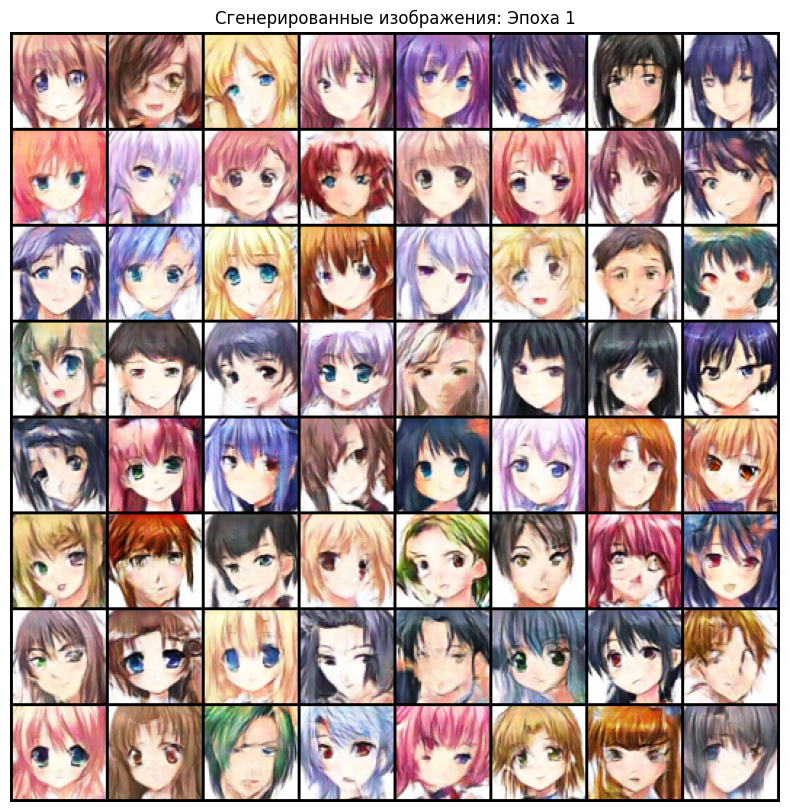

Изображения и веса сохранены для эпохи 1 в output.


Эпоха 2/15:  32%|███▏      | 319/994 [03:16<06:55,  1.62it/s, CritLoss=-9.1361, GenLoss=46.7539]

In [ ]:
gen, crit, gen_losses, crit_losses = train_wgan_gp(dataloader, generator, critic, opt_gen, opt_crit, num_epochs, z_dim, device, lambda_gp=10, critics_per_gen=5, output_dir="output")

## Валидация обученной модели

Для валидации будем использовать библиотеку `clean-fid`

In [20]:
!pip install clean-fid

In [21]:
import glob
import torch

# Найдем последнюю эпоху
weight_files = glob.glob("output/weights/netG_epoch_*.pth")

if weight_files:
    latest_epoch = max(
        int(f.split('_')[-1].split('.')[0])
        for f in weight_files
    )
    latest_weight_file = f"output/weights/netG_epoch_{latest_epoch:03d}.pth"

    state_dict = torch.load(latest_weight_file, map_location=device)
    generator.load_state_dict(state_dict)
    generator.eval()
else:
    print("Не найдены сохраненные веса, используем текущую модель")


In [22]:
from cleanfid import fid

def get_images_to_fid_format(images_list):
    """
    Преобразование картинок для clean-fid формата
    """
    all_images = torch.cat(images_list, dim=0)
    all_images = all_images * 0.5 + 0.5
    all_images = all_images.mul(255).add(0.5).clamp(0, 255).permute(0, 2, 3, 1).to('cpu', torch.uint8).numpy()
    return all_images

def save_images_to_folder(image_array, folder_path, max_to_save=None):
    """
    Сохранение изображений
    """
    os.makedirs(folder_path, exist_ok=True)

    num_images = image_array.shape[0]
    if max_to_save is not None and max_to_save < num_images:
        images_to_process = image_array[:max_to_save]
        print(f"Сохраняем первые {max_to_save} изображений в {folder_path}...")
    else:
        images_to_process = image_array
        print(f"Сохраняем все {num_images} изображений в {folder_path}...")

    for i in tqdm(range(images_to_process.shape[0]), desc=f"Сохранение в {os.path.basename(folder_path)}"):
        img = Image.fromarray(images_to_process[i])
        img.save(os.path.join(folder_path, f"{i:05d}.png"))


def calculate_final_fid_fixed(
    trained_gen,
    dataloader,
    z_dim,
    device,
    num_samples=10000,
    save_generated_path=None,
    save_real_path=None,
    max_saved_images=100
):
    """
    Собирает реальные и фейковые изображения, преобразует их,
    сохраняет во временные папки для FID и опционально сохраняет
    изображения в постоянные папки.
    """

    # 1. Сбор реальных изображений
    print("Собираем реальные изображения...")
    real_images_list = []
    for images, _ in dataloader:
        real_images_list.append(images.cpu())
        if len(real_images_list) * dataloader.batch_size >= num_samples:
             break
    real_images_array = get_images_to_fid_format(real_images_list)[:num_samples]

    if save_real_path:
        print(f"\nОбнаружен save_real_path. Сохраняем реальные изображения в: {save_real_path}")
        # Сохраняем только часть, определенную max_saved_images
        save_images_to_folder(real_images_array, save_real_path, max_to_save=max_saved_images)
        print("Сохранение реальных изображений завершено.")

    # 2. Генерация фейковых изображений
    print(f"\nГенерируем {num_samples} фейковых изображений...")
    trained_gen.eval()
    fake_images_list = []
    batch_size = dataloader.batch_size

    for i in tqdm(range(0, num_samples, batch_size)):
        current_batch_size = min(batch_size, num_samples - i)
        noise = torch.randn(current_batch_size, z_dim, 1, 1, device=device)
        with torch.no_grad():
            fake_batch = trained_gen(noise).cpu()
        fake_images_list.append(fake_batch)

    fake_images_array = get_images_to_fid_format(fake_images_list)

    if save_generated_path:
        print(f"\nОбнаружен save_generated_path. Сохраняем сгенерированные изображения в: {save_generated_path}")
        # Сохраняем только часть, определенную max_saved_images
        save_images_to_folder(fake_images_array, save_generated_path, max_to_save=max_saved_images)
        print("Сохранение сгенерированных изображений завершено.")

    # 3. Расчет FID: ИСПОЛЬЗУЕМ ВРЕМЕННЫЕ ПАПКИ
    print("\nНачинаем расчет FID...")

    with tempfile.TemporaryDirectory() as real_dir, tempfile.TemporaryDirectory() as fake_dir:

        # Для FID сохраняем все необходимые num_samples изображений
        print("Сохраняем реальные изображения во временную папку для FID...")
        save_images_to_folder(real_images_array, real_dir, max_to_save=None)

        print("Сохраняем фейковые изображения во временную папку для FID...")
        save_images_to_folder(fake_images_array, fake_dir, max_to_save=None)

        fid_value = fid.compute_fid(
            real_dir,
            fake_dir,
            model_name="inception_v3",
            device=device,
            verbose=True
        )
        return fid_value




In [23]:
final_fid_score = calculate_final_fid_fixed(
    trained_gen=generator,
    dataloader=dataloader,
    z_dim=z_dim,
    device=device,
    num_samples=10000,
    save_generated_path="generated_samples",
    save_real_path="real_samples",
    max_saved_images=100
)
final_fid_score

Собираем реальные изображения...

Обнаружен save_real_path. Сохраняем реальные изображения в: real_samples
Сохраняем первые 100 изображений в real_samples...


Сохранение в real_samples: 100%|██████████| 100/100 [00:00<00:00, 678.72it/s]


Сохранение реальных изображений завершено.

Генерируем 10000 фейковых изображений...


100%|██████████| 157/157 [00:01<00:00, 88.75it/s]



Обнаружен save_generated_path. Сохраняем сгенерированные изображения в: generated_samples
Сохраняем первые 100 изображений в generated_samples...


Сохранение в generated_samples: 100%|██████████| 100/100 [00:00<00:00, 767.43it/s]


Сохранение сгенерированных изображений завершено.

Начинаем расчет FID...
Сохраняем реальные изображения во временную папку для FID...
Сохраняем все 10000 изображений в /tmp/tmpokduvmhz...


Сохранение в tmpokduvmhz: 100%|██████████| 10000/10000 [00:15<00:00, 636.53it/s]


Сохраняем фейковые изображения во временную папку для FID...
Сохраняем все 10000 изображений в /tmp/tmpp2q08wsl...


Сохранение в tmpp2q08wsl: 100%|██████████| 10000/10000 [00:14<00:00, 683.90it/s]


compute FID between two folders


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Found 10000 images in the folder /tmp/tmpokduvmhz


FID tmpokduvmhz : 100%|██████████| 313/313 [01:29<00:00,  3.50it/s]


Found 10000 images in the folder /tmp/tmpp2q08wsl


FID tmpp2q08wsl : 100%|██████████| 313/313 [01:30<00:00,  3.44it/s]


np.float64(87.36471308853163)